# Relationship / Crime Type Analysis

In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import shapely
from geopy.geocoders import GoogleV3

## Data Pre-processing
Our main dataset is the National Incident-Based Reporting System (NIBRS) dataset from FBI. The data format is in CSV.

You can find the NIBRS dataset here:

- FBI crime data explorer. https://crime-data-explorer.fr.cloud.gov/downloads-and-docs

Following the collection of the data, there are 43 tables for a specific state-year combination that needs to be transformed into useful format. We also need to establish the relationships between tables, such as mapping `offense_type_id` into a *human-readable* string.

First, define the 43 table names as lists or dictionaries. We will reuse them in *loops* later. The lookup tables are stored in a dictionary of `{table_name: (oldCol, newCol)}` format.

In [2]:
# 11 primary (more important) tables
# Note that one incident is associated with up to 10 offenses
primaryTables = [
    "nibrs_arrestee", "nibrs_bias_motivation", "nibrs_incident", "nibrs_month",
    "nibrs_offender", "nibrs_offense", "nibrs_property_desc", "nibrs_property",
    "nibrs_victim_injury", "nibrs_victim_offender_rel", "nibrs_victim"
]

# 23 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    "nibrs_activity_type": None, "nibrs_age": None, "nibrs_arrest_type": None, 
    "nibrs_assignment_type": None, "nibrs_bias_list": None, "nibrs_circumstances": None,
    "nibrs_cleared_except": None,
    "nibrs_criminal_act_type": ("criminal_act_id", "criminal_act_name"),
    "nibrs_drug_measure_type": None, "nibrs_ethnicity": None,
    "nibrs_injury": None, "nibrs_justifiable_force": None,
    "nibrs_location_type": ("location_id", "location_name"),
    "nibrs_offense_type" : ("offense_type_id", "offense_name"), "nibrs_prop_desc_type": None,
    "nibrs_prop_loss_type": None,
    "nibrs_relationship": ("relationship_id", "relationship_name"),
    "nibrs_suspected_drug_type": None, "nibrs_using_list": None,
    "nibrs_victim_type": ("victim_type_id", "victim_type_name"),
    "nibrs_weapon_type": None, "ref_race": None, "ref_state": None
}

# 9 secondary (less important, just for human differentiation) tables
secondaryTables = [
    "agency_participation", "cde_agencies", "nibrs_arrestee_weapon", "nibrs_criminal_act",
    "nibrs_suspected_drug", "nibrs_suspect_using", "nibrs_victim_circumstances",
    "nibrs_victim_offense", "nibrs_weapon"
]

The following function reads all 43 CSVs into a **dictionary of DataFrames** for a particular dataset (e.g., `SC-2016`, or South California 2016). The dictionary keys are the NIBRS table names.

In [3]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., SC-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

# SC2016 = readCSVs('SC-2016')
PA2016 = readCSVs('PA-2016')

Reading all CSVs for PA-2016 dataset...
Finished reading 43 CSVs


To replace those *id*'s with human-readable strings, we will first create a nested dictionary of `{(oldCol, newCol): {oldValue: newValue}}` format from a lookup table. This nested dictionary can be reused by any dataset.

Following the style of the previous cell, we use a for loop to create a nested dictionary.

In [4]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 5 lookup tables


Finally, using the previously created nested dictionary, we will call [DataFrame.replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) with another nested dictionary argument of `{oldCol: {oldValue, newValue}}` format to perform the replacement in place. Also, we will rename this `oldCol` as `newCol` for better readability.

In [5]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        # Build the nested dictionary required by df.replace()
        oldCol, newCol = lookupTables[lookupTableName]
        dic = {oldCol: maps[(oldCol, newCol)]}        
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and Renaming columns...')
replaceAndRename(PA2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(PA2016['nibrs_victim'], ['nibrs_victim_type'])
replaceAndRename(PA2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
print('Done')
# SC2016['nibrs_offense'].head()
# SC2016['nibrs_victim'].head()

Replacing and Renaming columns...
Done


In [6]:
# Helper function for plotting sns.countplot given df, col, and topK
def countPlot(df, col, topK=None, dpi = 100):
    plt.figure(figsize=(8,6), dpi=dpi)
    # Only show top K counts. Default: all counts
#     print(df[col].value_counts().index[:topK])
    topIndices = df[col].value_counts().index[:topK]
    sns.countplot(y = df[col], order = topIndices)
    return list(topIndices)
    

# Joining the tables

In order to analyze the relationship between the `relationship between victim/offender` and `offense type`, we first need to join three dataframes we need, which would be `nibrs_victim_offense`, `nibrs_offense`, and `nibrs_victim_offender_rel`. The NIBRS dataset includes non-human objects such as places or properties as victim. Since there's no relationship between a place or object and a human (or actually there is?), we should get a smaller joined dataframe after the joining process.

In [7]:
victim = PA2016["nibrs_victim_offense"]
print(len(victim))
print(len(victim["offense_id"].unique()))
victim.head()

6684
6107


,victim_id,offense_id
0,91038017,91124963
1,91038028,91124972
2,91526928,91618994
3,91526926,91618994
4,92412201,92509421


Here we plot the top K common offense type in our data set. Note that the frquency here might not be consistent with the joining results.

6107


,offense_id,incident_id,offense_name,location_name
0,91124963,83457465,Theft From Building,Residence/Home
1,91124972,83457473,Drug Equipment Violations,Highway/Road/Ally
2,91618994,83886692,Simple Assault,Parking Lot/Garage
3,92509421,84661377,Drug Equipment Violations,Residence/Home
4,92508047,84661375,Simple Assault,Residence/Home


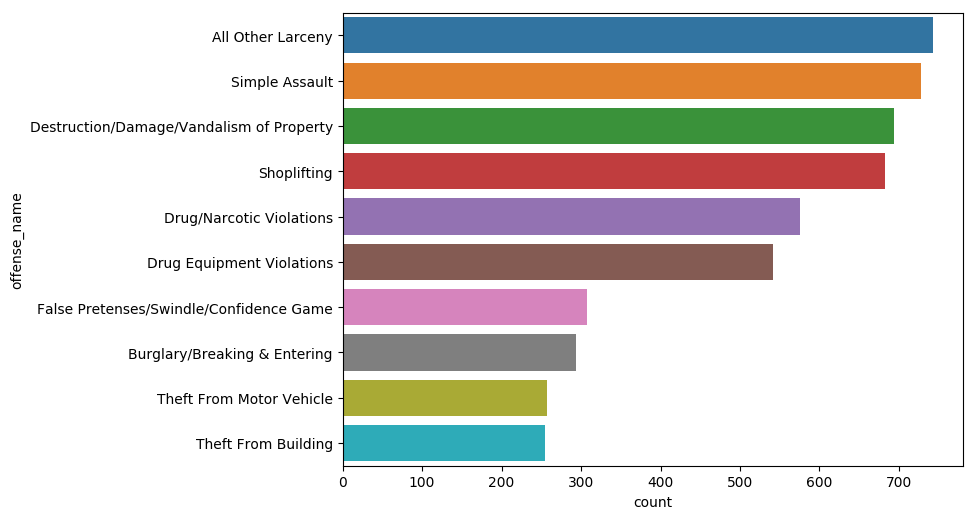

In [8]:
offense = PA2016["nibrs_offense"][["offense_id", "incident_id", "offense_name", "location_name"]]
print(len(offense))
topCrimeTypes = countPlot(offense, "offense_name", 10)
offense.head()

In [9]:
rel = PA2016["nibrs_victim_offender_rel"]
print(len(rel))
rel.head()

1277


,victim_id,offender_id,relationship_name,nibrs_victim_offender_id
0,91526928,94571285,Victim Was Acquaintance,27648864
1,91526928,94571283,Victim Was Acquaintance,27648863
2,91526926,94571285,Victim Was Acquaintance,27648862
3,91526926,94571283,Victim Was Acquaintance,27648076
4,92410630,95465950,Victim Was Boyfriend/Girlfriend,27913447


The joined dataframe has 1344 rows in it and not all top 10 offense types show up in it. This is because either the `nibrs_victim_offender_rel` table is not complete, or the victims of a particular offense type is not human (thus has no relationship between offender and victim based on the reasoning in the previous cell).

In [10]:
joinedVictimOffense = victim.merge(right = offense, on = "offense_id", how = "inner")\
                            .merge(right = rel, on = "victim_id", how = "inner")
print(len(joinedVictimOffense))
joinedVictimOffense.head()
# print(topCrimeTypes)
joinedVictimOffense = joinedVictimOffense[joinedVictimOffense["offense_name"].isin(topCrimeTypes)]
print(len(joinedVictimOffense))
print(joinedVictimOffense["offense_name"].unique())

1344
977
['Simple Assault' 'All Other Larceny' 'Burglary/Breaking & Entering'
 'Destruction/Damage/Vandalism of Property' 'Theft From Motor Vehicle'
 'Theft From Building']


First thing we could do with our processed data is to do the counting plot of it. In our plot we found that there's a huge inbalance in our dataset that `Simple Assault` offenses are way more common than other offense type. To address this issue, we could normalize the data w.r.t the offense type itself.

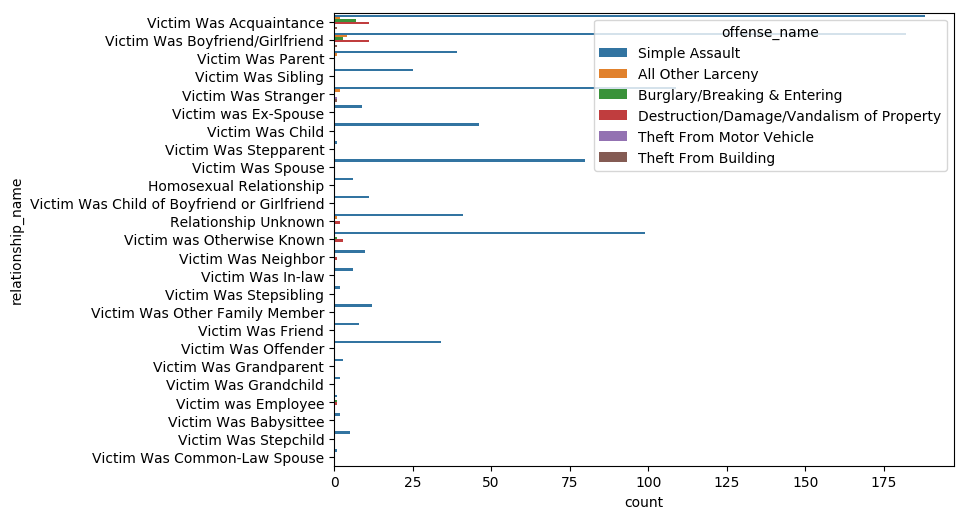

In [11]:
# joinedVictimOffense
plt.figure(figsize=(8,6), dpi=100)
ax = sns.countplot(y = "relationship_name", hue = "offense_name", data = joinedVictimOffense)


In order to normalize the data, filtering out each offense type for computing the normalized values in each series.

In [12]:
filteredDFS = []
# Filter df on the offense name
for offenseName in joinedVictimOffense["offense_name"].unique():
    filteredDFS.append((offenseName, joinedVictimOffense.loc[joinedVictimOffense["offense_name"] == offenseName]))

# Check the number of rows in each df
for element in filteredDFS:
    print(len(element[1]))

922
10
12
29
1
3


Finally, we would like to normalize the relationship counts in each offense type to show the distribution. After normalizing the data, we could concatenate the normalized series into one dataframe and could draw the distribution of each offense name and its distribution as a side-by-side barplot using seaborn's `factorplot`. 

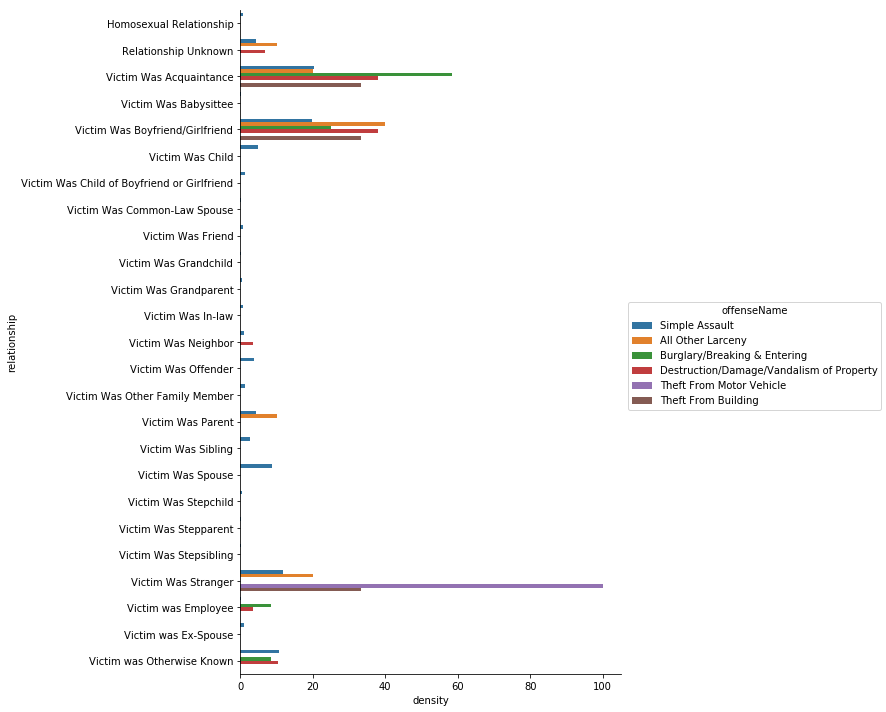

In [13]:
# https://stackoverflow.com/questions/18083187/combining-two-series-in-pandas-along-their-index
# Use "concat" to concat two series with different indices or dimensions
normalizedDFS = [(df[0], pd.Series(df[1]["relationship_name"]).value_counts(normalize=True, sort=False)*100) for df in filteredDFS]
concatDF = pd.concat([elem[1] for elem in normalizedDFS], axis = 1).fillna(value = 0.0).reset_index()
concatDF.columns = ["relationship"] + [elem[0] for elem in normalizedDFS]
reshapeDF = pd.melt(concatDF, id_vars="relationship", var_name="offenseName", value_name="density")
sns.factorplot(x="density", y="relationship", hue="offenseName", data = newDF, kind= "bar", size = 10)

# TODO: Analysis